### OpenApi Covid 크롤러

In [ ]:
from matplotlib import ticker

datatest = "{0}{1:0>2}{2:0>2}".format(str(2023), str(12), str(31))

In [ ]:
type(datatest)

In [ ]:
for i in range(1, 13):
  print(i)

In [ ]:
respnseDatatest = getRequestUrl("https://apis.data.go.kr/1352000/ODMS_COVID_02/callCovid02Api?apiType=JSON&serviceKey=PrnCXubPpC7QR6yoJ3Fe2us5MIA%2Bcr8zHjEm0Er26tGnMHOFTv9lz47fAygM%2Fo4cTZZroZwtX9t2NjeEADvfgw%3D%3D&status_dt=20211028")

In [ ]:
getCovidStatsItem("20200932")

In [ ]:
import calendar
import datetime as dt
import pandas as pd

In [ ]:
calendar.monthrange(2020, 10)[1] + 1

In [ ]:
date = '20201028'
x = dt.datetime.strptime(date, '%Y%m%d')
type(x.year)
# print(x.month)
# print(x.day)

In [ ]:
x

In [ ]:
start_date = '20201028'
end_date = '20201130'

x = dt.datetime.strptime(start_date, '%Y%m%d')
y = dt.datetime.strptime(end_date, '%Y%m%d')

In [ ]:
while x <= y:
    print(x)
    x += dt.timedelta(days=1)

In [ ]:
pr = pd.period_range(start='20201028',end='20201231', freq='D')
for j in pr:
    print('조회결과: {}'.format(str(i).replace('-','')))
    test = j.strftime('%Y%m%d') 
    # startDate = test
    print(test)
    print(type(test))

In [ ]:
#[CODE 3]
def getCovidstatsService(statusDt, endStatusDt):
    jsonResult=[]
    result = []
    statusDt = dt.datetime.strptime(statusDt, '%Y%m%d')
    endStatusDt = dt.datetime.strptime(endStatusDt, '%Y%m%d')
    
    
    pr_test = pd.period_range(start=str(statusDt),end=str(endStatusDt), freq='D')
    pr_main = pr.format(str(pr_test).replace('-',''))
    
    dataEnd = "{0}{1:0>2}{2:0>2}".format(str(endStatusDt), str(12), str(31))
    isDataEnd = 0

    for i in range(pr_main):
            if(isDataEnd == 1) : break
            startDate = i.strftime('%Y%m%d') 
            jsonData = getCovidStatsItem(startDate)
            
            if(jsonData['resultMsg'] == 'NORMAL SERVICE'):
                if jsonData['items'] == '':
                    isDataEnd = 1
                    dataEnd = str(endStatusDt) 
                    print("데이터 없음.... \n 제공되는 통계 데이터는 %s년 %s월 %s일 까지입니다." % (str(startDate.year), str(startDate.month), str(startDate.day)))
                    break
                    
                print(json.dumps(jsonData, indent=4, sort_keys=True, ensure_ascii=False))

                pageNo = jsonData['pageNo']
                resultCode = jsonData['resultCode']
                totalCount = jsonData['totalCount']
                
                accDefRate = jsonData['items'][0]['accDefRate']
                accExamCnt = jsonData['items'][0]['accExamCnt']
                accExamCompCnt = jsonData['items'][0]['accExamCompCnt']
                careCnt = jsonData['items'][0]['careCnt']
                dPntCnt = jsonData['items'][0]['dPntCnt']
                gPntCnt = jsonData['items'][0]['gPntCnt']
                hPntCnt = jsonData['items'][0]['hPntCnt']
                resutlNegCnt = jsonData['items'][0]['resutlNegCnt']
                statusDt = jsonData['items'][0]['statusDt']
                statusTime = jsonData['items'][0]['statusTime']
                uPntCnt = jsonData['items'][0]['uPntCnt']

                numOfRows = jsonData['numOfRows']
                resultMsg = jsonData['resultMsg']
                
                print('----------------------------------------------------------------------')
                jsonResult.append({'pageNo' : pageNo,
                                   'resultCode' : resultCode,
                                   'totalCount': totalCount,
                                   'items' : [{
                                       'accDefRate' : accDefRate,
                                       'accExamCnt' : accExamCnt,
                                       'accExamCompCnt' :accExamCompCnt,
                                        'careCnt' : careCnt,
                                        'dPntCnt' : dPntCnt,
                                        'gPntCnt' : gPntCnt,
                                        'hPntCnt': hPntCnt,
                                        'resultNegCnt' : resutlNegCnt,
                                        'statusDt' : statusDt,
                                        'statusTime' : statusTime ,
                                        'uPntCnt' : uPntCnt
                                   }],
                                    'numOfRows' : numOfRows,
                                    'resultMsg' : resultMsg
                                })
                result.append(jsonResult)
                    
    return (jsonResult, result, dataEnd, totalCount)

## 필요한 패키지 import

In [8]:
import os
import sys
import urllib.request
import datetime
import time
import json
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import datetime as dt

### ServiceKey 정보 입력

In [2]:
serviceKey = "PrnCXubPpC7QR6yoJ3Fe2us5MIA%2Bcr8zHjEm0Er26tGnMHOFTv9lz47fAygM%2Fo4cTZZroZwtX9t2NjeEADvfgw%3D%3D"

### 크롤러에 필요한 함수 선언

In [3]:
#[Code 1]
def getRequestUrl(url):
    req = urllib.request.Request(url)
    try:
        response = urllib.request.urlopen(req)
        if response.getcode() == 200:
            print("[%s] Url Request Success" % datetime.datetime.now())
            print(response.headers)
            return response.read().decode("utf-8")
    except Exception as e:
            print(e)
            print("[%s] Error for URL : %s" % (datetime.datetime.now(), url))
            return None

In [4]:
#[CODE 2]
def getCovidStatsItem(status_dt):
    service_url = "http://apis.data.go.kr/1352000/ODMS_COVID_02/callCovid02Api"
    parameters = "?apiType=JSON&serviceKey=" + serviceKey
    parameters += "&status_dt=" + status_dt
    # parameters += "&numOfRows=" + numOfRows
    # parameters += "&pageNo=" + pageNo

    url = service_url + parameters

    response_data = getRequestUrl(url)
    
    
    if (response_data == None):
        return None
    else:
        return json.loads(response_data)


In [5]:
#[CODE 3]
def getCovidstatsService(statusDt, endStatusDt):
    jsonResult=[]
    result = []
    statusDt = dt.datetime.strptime(statusDt, '%Y%m%d')
    endStatusDt = dt.datetime.strptime(endStatusDt, '%Y%m%d')
    
    
    pr_test = pd.period_range(start=statusDt,end=endStatusDt, freq='D')
    
    dataEnd = "{0}{1:0>2}{2:0>2}".format(str(endStatusDt), str(12), str(31))
    isDataEnd = 0

    for i in pr_test:
            if(isDataEnd == 1) : break
            # startDate = "{0}{1:0>2}{2:0>2}".format(str(i).replace('-',''))
            startDate = i.strftime('%Y%m%d')
            jsonData = getCovidStatsItem(startDate)
            
            
            if(jsonData['resultMsg'] == 'NORMAL SERVICE'):
                if jsonData['items'] == '':
                    isDataEnd = 1
                    dataEnd = str(endStatusDt) 
                    print("데이터 없음.... \n 제공되는 통계 데이터는 %s년 %s월 %s일 까지입니다." % (str(startDate.year), str(startDate.month), str(startDate.day)))
                    break
                    
                print(json.dumps(jsonData, indent=4, sort_keys=True, ensure_ascii=False))
                
                accDefRate = jsonData['items'][0]['accDefRate']
                accExamCnt = jsonData['items'][0]['accExamCnt']
                accExamCompCnt = jsonData['items'][0]['accExamCompCnt']
                careCnt = jsonData['items'][0]['careCnt']
                dPntCnt = jsonData['items'][0]['dPntCnt']
                gPntCnt = jsonData['items'][0]['gPntCnt']
                hPntCnt = jsonData['items'][0]['hPntCnt']
                resutlNegCnt = jsonData['items'][0]['resutlNegCnt']
                statusDt = jsonData['items'][0]['statusDt']
                statusTime = jsonData['items'][0]['statusTime']
                uPntCnt = jsonData['items'][0]['uPntCnt']
            
                pageNo = jsonData['pageNo']
                resultCode = jsonData['resultCode']
                totalCount = jsonData['totalCount']
                
                numOfRows = jsonData['numOfRows']
                resultMsg = jsonData['resultMsg']
                
                print('----------------------------------------------------------------------')
                jsonResult.append({
                                    'accDefRate' : accDefRate,
                                    'accExamCnt' : accExamCnt,
                                    'accExamCompCnt' :accExamCompCnt,
                                    'careCnt' : careCnt,
                                    'dPntCnt' : dPntCnt,
                                    'gPntCnt' : gPntCnt,
                                    'hPntCnt': hPntCnt,
                                    'resultNegCnt' : resutlNegCnt,
                                    'statusDt' : statusDt,
                                    'statusTime' : statusTime ,
                                    'uPntCnt' : uPntCnt,
                                    'pageNo' : pageNo,
                                    'resultCode' : resultCode,
                                    'totalCount': totalCount,
                                    'numOfRows' : numOfRows,
                                    'resultMsg' : resultMsg
                                })
                result.append(jsonResult)
                    
    return (jsonResult, result, dataEnd, totalCount)

In [6]:
def main():
    jsonResult = []
    result = []
    print("보건복지부_코로나19 감염현황 총괄 통계 데이터를 수집합니다.")
    # pageNo = input('페이지 번호를 입력하세요')
    # numOfRows = input('한 페이지에 표시되는 데이터 수를 입력하세요')
    statusDt = input('데이터를 몇 년부터 수집할까요? : ')
    endStatusDt = input('데이터를 몇 년까지 수집할까요? : ')

    jsonResult, result, dataEnd, totalCount = getCovidstatsService(statusDt, endStatusDt)

    if (totalCount==0) : #URL 요청은 성공하였지만, 데이터 제공이 안된 경우
        print('데이터가 전달되지 않았습니다. 공공데이터포털의 서비스 상태를 확인하기 바랍니다.')
    else:
        with open(f'./{statusDt}_{endStatusDt}.json','w', encoding="utf-8") as outfile:
            jsonFile = json.dumps(jsonResult, indent=4, sort_keys=False, ensure_ascii=False)
            outfile.write(jsonFile)
        # colums1 = ['accDefRate', 
        #           'accExamCnt', 
        #           'accExamCompCnt', 
        #           'careCnt', 
        #           'dPntCnt', 
        #           'gPntCnt', 
        #           'hPntCnt', 
        #           'resultNegCnt', 
        #           'statusDt', 
        #           'statusTime', 
        #           'uPntCnt',            
        #           'numOfRows', 
        #           'pageNo', 
        #           'resultCode', 
        #           'resultMsg', 
        #           'totalCount'
        #           'numOfRows', 
        #           'pageNo', 
        #           'resultCode', 
        #           'resultMsg', 
        #           'totalCount']
        # df1 = pd.DataFrame({colums1 : result})
        # result_df = pd.DataFrame({colums : result})
        # result_df = pd.DataFrame(result, columns=colums)
        result_df = pd.read_json(f'./{statusDt}_{endStatusDt}.json')
        result_df.rename(columns={'accDefRate' : '누적확진율', 
                  'accExamCnt' : '누적검사수', 
                  'accExamCompCnt' : '누적검사완료수', 
                  'careCnt' : '치료중환자수', 
                  'dPntCnt' : '격리해제수', 
                  'gPntCnt' : '사망자수', 
                  'hPntCnt' : '확진자수', 
                  'numOfRows' : '한 페이지 결과 수', 
                  'pageNo' : '페이지 번호', 
                  'resultCode' : '결과코드', 
                  'resultMsg' : '결과메시지',                  
                  'resultNegCnt' : '결과음성수', 
                  'statusDt' : '기준일자', 
                  'statusTime' : '기준시간',
                  'totalCount' : '전체 결과 수',
                  'uPntCnt' : '검사중수'}, inplace=True)
        result_df.to_csv(f'./{statusDt}_{endStatusDt}.csv', index=False, encoding="utf-8")

### 실행

In [9]:
if __name__ == '__main__':
    main()

보건복지부_코로나19 감염현황 총괄 통계 데이터를 수집합니다.
[2024-04-30 14:10:37.920613] Url Request Success
Set-Cookie: JSESSIONID=1rBEl86YL-Ix00prpx9zpKudaaSifdZtf9jzQY8v.ODMS3; Path=/1352000/ODMS_COVID_02; Domain=apis.data.go.kr
Access-Control-Allow-Origin: *
Content-Type: application/json;charset=UTF-8
Content-Length: 338
Date: Tue, 30 Apr 2024 05:10:36 GMT
Connection: close
Server: NIA API Server


{
    "items": [
        {
            "accDefRate": "1.021305784",
            "accExamCnt": "2582960",
            "accExamCompCnt": "2560056",
            "careCnt": "1617",
            "dPntCnt": "24068",
            "gPntCnt": "461",
            "hPntCnt": "26146",
            "resutlNegCnt": "2533910",
            "statusDt": "20201028",
            "statusTime": "00:00",
            "uPntCnt": "22904"
        }
    ],
    "numOfRows": "500",
    "pageNo": "1",
    "resultCode": "00",
    "resultMsg": "NORMAL SERVICE",
    "totalCount": 1
}
-----------------------------------------------------------------

## 데이터 시각화

In [42]:
data_csv = './20201028_20210228.csv'
# CSV 파일 읽기
df = pd.read_csv(data_csv)

In [46]:
# '기준일'을 Datetime 형식으로 변환
if '기준일자' not in df.columns:
    raise ValueError("CSV 파일에 '기준일자' 컬럼이 없습니다.")

df['기준일자'] = pd.to_datetime(df['기준일자'], format='%Y%m%d', errors='coerce')  # 날짜 변환
if df['기준일자'].isna().any():
    raise ValueError("날짜 변환 중 오류가 발생했습니다.")

# 월별 데이터 그룹화
df['기준월'] = df['기준일자'].dt.to_period('M')  # 월 단위로 변환

# 월별로 합계 또는 평균을 계산
monthly_data = df.groupby('기준월').agg({
    '누적확진율': 'mean',  # 누적확진률은 평균값으로
    '누적검사수' : 'sum',
    '누적검사완료수': 'sum',
    '치료중환자수': 'sum',
    '격리해제수' : 'sum',
    '사망자수' : 'sum',
    '확진자수' : 'sum',
    '결과음성수' : 'sum',
    '검사중수' : 'sum',
}).reset_index()

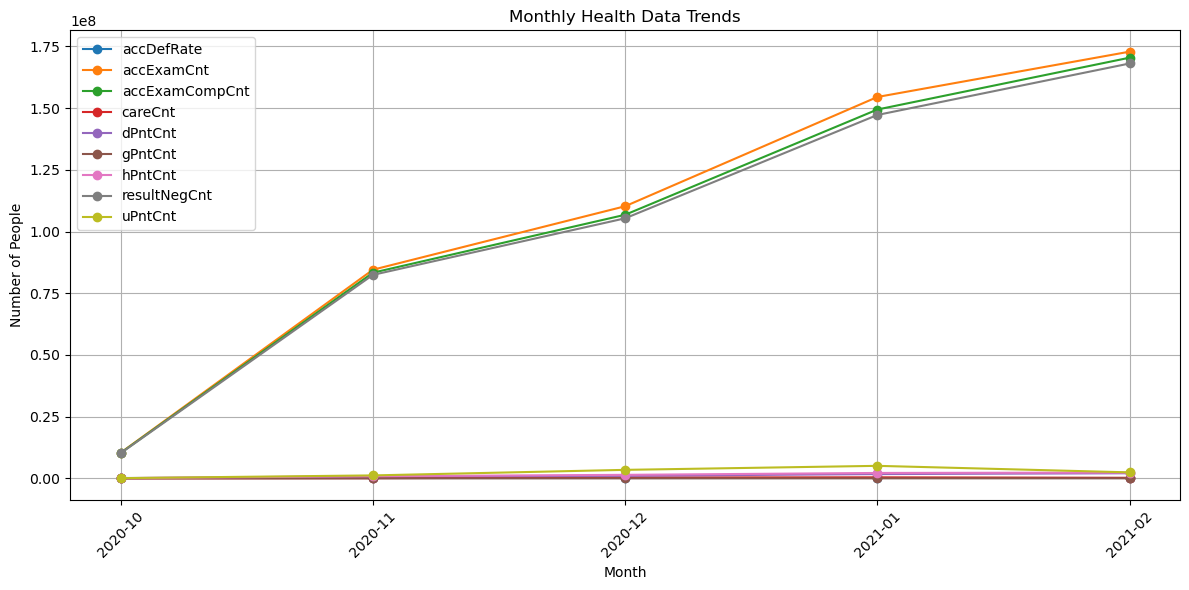

In [47]:
# 월별 데이터로 라인 플롯 그리기
plt.figure(figsize=(12, 6))
plt.plot(monthly_data['기준월'].astype(str), monthly_data['누적확진율'], marker='o', label='accDefRate')
plt.plot(monthly_data['기준월'].astype(str), monthly_data['누적검사수'], marker='o', label='accExamCnt')
plt.plot(monthly_data['기준월'].astype(str), monthly_data['누적검사완료수'], marker='o', label='accExamCompCnt')
plt.plot(monthly_data['기준월'].astype(str), monthly_data['치료중환자수'], marker='o', label='careCnt')
plt.plot(monthly_data['기준월'].astype(str), monthly_data['격리해제수'], marker='o', label='dPntCnt')
plt.plot(monthly_data['기준월'].astype(str), monthly_data['사망자수'], marker='o', label='gPntCnt')
plt.plot(monthly_data['기준월'].astype(str), monthly_data['확진자수'], marker='o', label='hPntCnt')
plt.plot(monthly_data['기준월'].astype(str), monthly_data['결과음성수'], marker='o', label='resultNegCnt')
plt.plot(monthly_data['기준월'].astype(str), monthly_data['검사중수'], marker='o', label='uPntCnt')

# 그래프 설정
plt.xlabel('Month')  # X축 레이블
plt.ylabel('Number of People')  # Y축 레이블
plt.title('Monthly Health Data Trends')  # 그래프 타이틀
plt.xticks(rotation=45)  # X축 레이블 회전
plt.legend()  # 범례
plt.grid(True)  # 그리드 표시
plt.tight_layout()  # 레이아웃 조정
plt.show()  # 그래프 표시